This notebook is part of the `deepcell-tf` documentation: https://deepcell.readthedocs.io/.

# Training a segmentation model

`deepcell-tf` leverages [Jupyter Notebooks](https://jupyter.org) in order to train models. Example notebooks are available for most model architectures in the [notebooks folder](https://github.com/vanvalenlab/deepcell-tf/tree/master/notebooks). Most notebooks are structured similarly to this example and thus this notebook serves as a core reference for the deepcell approach to model training.

In [1]:
import os
import errno
import pandas as pd
import numpy as np
import glob
import statistics

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.segmentation import relabel_sequential
from skimage.transform import rescale, resize
from skimage.morphology import remove_small_objects
from skimage.measure import regionprops
from skimage.feature import peak_local_max
from IPython.display import HTML

import deepcell
from deepcell.utils.plot_utils import get_js_video
from deepcell_toolbox.deep_watershed import deep_watershed_3D
from deepcell_toolbox.utils import tile_image_3D, untile_image_3D

## Load data

In [2]:
def load_mousebrain_data(filepath, set_nums, test_size=0.2, seed=0):
    X = []
    y = []

    for set_num in range(set_nums):
        path_to_folder = os.path.join(filepath, 'mov_{}'.format(set_num))

        for path_to_npz in glob.glob(os.path.join(path_to_folder, '*.npz')):
            with np.load(path_to_npz) as load_data:
                X.append(np.expand_dims(load_data['X'][..., 0], axis=-1))
                y.append(load_data['y'])

    X = np.asarray(X)
    y = np.asarray(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

    return X_train, X_test, y_train, y_test

In [3]:
filepath = '/images/data/cells/MouseBrain/3D_annotations/attempt2'
set_nums = 4
test_size = 0.2
seed = 7

X_train, X_test, y_train, y_test = load_mousebrain_data(filepath, set_nums, test_size=test_size, seed=seed)
print('X_train.shape: {}\ty_train.shape: {}'.format(X_train.shape, y_train.shape))
print('X_test.shape: {}\ty_test.shape: {}'.format(X_test.shape, y_test.shape))

X_train.shape: (11, 47, 512, 512, 1)	y_train.shape: (11, 47, 512, 512, 1)
X_test.shape: (3, 47, 512, 512, 1)	y_test.shape: (3, 47, 512, 512, 1)


## Set up filepath constants


In [4]:
filename = '--.npz'

DATA_DIR = os.path.expanduser(os.path.join(filepath))

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

# save models on madrox
ROOT_DIR = '/deepcell_data'
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## View cell statistics

In [5]:
def get_3D_cell_statistics(images, precision=2, channel=0):

    if images.ndim != 5:
        raise ValueError('Input images must have ndims = 5 (batch, z, x, y, channels)'
                         'Given input had ndims = {}, with shape '.format(images.ndim, images.shape))
    z_dims = []
    x_dims = []
    y_dims = []
    for batch in range(images.shape[0]):
        regions = regionprops(images[batch, ..., channel])
        for region in regions:
            bbox = region.bbox
            z_dims.append(bbox[3] - bbox[0])
            x_dims.append(bbox[4] - bbox[1])
            y_dims.append(bbox[5] - bbox[2])

    stats = {}
    stats['z_mean'] = np.round(statistics.mean(z_dims), precision)
    stats['x_mean'] = np.round(statistics.mean(x_dims), precision)
    stats['y_mean'] = np.round(statistics.mean(y_dims), precision)
    stats['z_med'] = np.round(statistics.median(z_dims), precision)
    stats['x_med'] = np.round(statistics.median(x_dims), precision)
    stats['y_med'] = np.round(statistics.median(y_dims), precision)
    return stats

In [6]:
stats = get_3D_cell_statistics(np.concatenate((y_train, y_test), axis=0))

print('Cell dimensions: mean x is {}, mean y is {}, and mean z is {}'.format(
    stats['x_mean'], stats['y_mean'], stats['z_mean']))

Cell dimensions: mean x is 36.07, mean y is 38.4, and mean z is 15.95


## Prepare data

### Set up input and augmentation parameters
**model_name**: Incorporated into any files generated during the training process.

**frame_shape**: Defines the x & y dimensions of the model input. They must be equivalent powers of 2. A good starting point is to set this as the smallest power of 2 that is greater than the mean x & y dimensions. 

**frames_per_batch**: Defines the z dimensions of the model input. Can be any integer ranging from 1 to the max height of the data. A good starting point is to set this as just greater than the mean cell height. 

**aug_3d**: Whether or not to perform 3d spatial data augmentation. With just this flag on, the only augmentation performed in 3d is flipping. It is recommended to leave this on for all 3d data. 

**rotation_3d**: Choose the range in degrees for rotation in 3d (rotating the xz and yz planes in addition to xy). Highly recommended to start out leaving this at 0. Can experiment with increasing this - if so, I would recommend staying within the range of 1-15. Larger rotation ranges result in significant clipping out of data. It should also be noted that using 3d_rotation *significantly* slows down training, as each batch is individually scaled down before being returned. 

**sampling**: The pixelwise sampling ratio for the data - sampling along the z-axis tends to be of a lower resolution compared with x & y. This will be different for most datasets, and MUST be entered. If this is not known for your dataset, a rough sampling approximation (assuming x and y are scaled the same, which they typically are) can be calculated using the mean cell dimensions as follows:      
((x+y)/2)/z = z_scale -----------> example: ((36.07+38.4)/2)/15.95 = 2.33, actual scale = 0.5/0.217 = 2.30       
sampling = [z_scale, 1, 1]

**by_frame_inner**: If False, transform inner-distance (used to identify cell centroids) in 3D. Must ALWAYS be False for 3d data.

**by_frame_outer**: If False, transform outer-distance (used to define cell area) in 3D. Generally should be 3D, but can sometimes be beneficial to set this to True (performing this transform in 2D). 

**temporal_mode**: Method by which temporal features (in this case the z-stack along the z-axis) are merged in model construction. One of None, 'conv', 'gru', or 'lstm'. Lstm mode seems to be broken, and the others do not seem to provide significant benefit. **Not sure if working as intended - would recommend taking another look before using.**

**z_axis_convolutions**: Whether or not to perform convolutions along the z-axis. Should theoretically be equivalent to temporal_mode==conv. Would recommend starting with this on (True).

**fill_mode**: When performing rotation, part of the image will be clipped out, leaving an empty space in its place - fill_mode determines what will replace that empty space. One of 'constant', 'nearest', 'reflect', and 'wrap'. Best options seem to be 'constant' and 'nearest', as both 'reflect' and 'wrap' have the potential to create fused "cells" that have 2 centroids. 

**min_objects**: Images with less than this number of objects are thrown out. This actually does not work with the cropping implementation (as the "given input image" is the entire image, not the crop - so typically nothing will get thrown out). One useful improvement would be development of a cropping data generator for 3d (see the 2d cropping datagen), so that minimum objects could be applied to individual crops. 

**batch_size**: The batch size determines the number of samples that are processed before the model is updated. The value must be greater than one and less than or equal to the number of samples in the training dataset. Make this as large as possible, but memory will be an issue - somewhere between 1 and 4 is likely realistic. 

In [7]:
model_name = 'mousebrain3D_27x64_random_cropping_3daug_norotatev2'

frame_shape = (64, 64, 1)           # Change depending on cell dimensions and what fits in memory
frames_per_batch = 20               # Change depending on cell dimensions and what fits in memory

aug_3d = True                       # Leave at True
rotation_3d = 0                     # Should generally leave this at 0
sampling = [0.5, 0.217, 0.217]      # Need dataset metadata to set this - can roughly calculate as described above
z_scale = sampling[0] / sampling[1]

if aug_3d and rotation_3d > 0:
    sampling = [sampling[1], sampling[1], sampling[1]]

by_frame_inner = False        # Always leave as False
by_frame_outer = False        # Default to False, can try changing to True
temporal_mode = None          # Default to None, can experiment with 'gru' and 'conv'
z_axis_convolutions = True    # Default to True, can experiment with changing to False

fill_mode = 'constant'        # Default to 'constant', can experiment with changing to 'nearest'
cval = 0                      # Leave this at 0. 
min_objects = 1               # Doesn't matter - doesn't work with current cropping implementation
batch_size = 4                # Bigger is better, too big won't fit in memory - change based on input shape

In [8]:
from deepcell import image_generators
from deepcell.utils import train_utils

transforms = ['inner-distance', 'outer-distance', 'fgbg', 'pixelwise']
transforms_kwargs = {'outer-distance': {'erosion_width': 0, 'by_frame' : by_frame_outer, 'sampling': sampling},
                     'inner-distance': {'by_frame' : by_frame_inner, 'sampling': sampling}}

# use augmentation for training but not validation
datagen = image_generators.Semantic3DGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    fill_mode=fill_mode,
    cval=cval,
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.Semantic3DGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    fill_mode=fill_mode,
    cval=cval,
    horizontal_flip=0,
    vertical_flip=0)

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    frames_per_batch=frames_per_batch,
    frame_shape=frame_shape,
    transforms_kwargs=transforms_kwargs,
    aug_3d=aug_3d,
    rotation_3d=rotation_3d,
    z_scale=z_scale,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    frames_per_batch=frames_per_batch,
    frame_shape=frame_shape,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    aug_3d=False,
    rotation_3d=0,
    min_objects=min_objects,
    batch_size=batch_size)

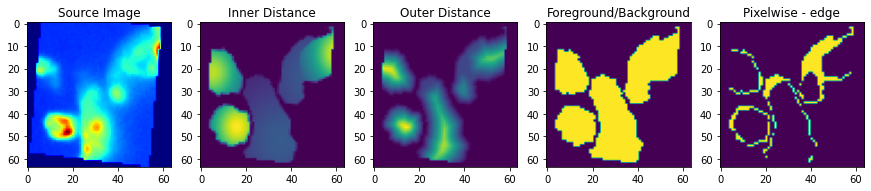

In [9]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]
pixelwise = outputs[3]

fig, axes = plt.subplots(1, 5, figsize=(15, 15))

slice=12

axes[0].imshow(img[slice, ..., 0], cmap='jet')
axes[0].set_title('Source Image')

axes[1].imshow(inner_distance[0, slice, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, slice, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, slice, ..., 1])
axes[3].set_title('Foreground/Background')

axes[4].imshow(pixelwise[0, slice, ..., 0])
axes[4].set_title('Pixelwise - edge')

plt.show()

In [10]:
HTML(get_js_video(inputs, batch=0, channel=0, interval=100, cmap='jet'))

## Create the PanopticNet Model

Here we instantiate a `PanopticNet` model from `deepcell.model_zoo` using 3 semantic heads:
inner distance (1 class),
outer distance (1 class),
foreground/background distance (2 classes)

In [9]:
if frame_shape:
    input_shape = frame_shape
else:
    input_shape = X_train.shape[2:]

In [11]:
from deepcell.model_zoo.panopticnet import PanopticNet
    
model = PanopticNet(
    backbone='resnet50',
    input_shape=input_shape,
    frames_per_batch=frames_per_batch, 
    norm_method='std',
    num_semantic_heads=4,
    temporal_mode=temporal_mode,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg
    location=True,  # should always be true
    include_top=True,
    z_axis_convolutions=z_axis_convolutions)

W0807 20:57:59.879067 140699637471040 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Using convolutions across the z-axis
Using convolutions across the z-axis
Using convolutions across the z-axis


## Prepare for training

### Set up training parameters.

**n_epoch**: The number of complete passes through the training dataset.

**optimizer**: The TensorFlow module [tf.keras.optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) offers optimizers with a variety of algorithm implementations. DeepCell typically uses the Adam or the SGD optimizers.

**lr**: The learning rate determines the speed at which the model learns. Specifically it controls the relative size of the updates to model values after each batch.

**lr_sched**: A learning rate scheduler allows the learning rate to adapt over the course of model training. Typically a larger learning rate is preferred during the start of the training process, while a small learning rate allows for fine-tuning during the end of training.

In [12]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

n_epoch = 20 
test_size = .20
optimizer = Adam(lr=1e-5, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-5, decay=0.99)
model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

### Create a loss function for each semantic head

Each semantic head is trained with it's own loss function. Mean Square Error is used for regression-based heads, whereas `weighted_categorical_crossentropy` is used for classification heads.

The losses are saved as a dictionary and passed to `model.compile`.

In [13]:
# Create a dictionary of losses for each semantic head
from tensorflow.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [14]:
model.compile(loss=loss, optimizer=optimizer)

## Train the model

Call `fit_generator` on the compiled model, along with a default set of callbacks.

In [15]:
# Compensate for cropping by increasing the number of steps per epoch proportionally
cropping_factor = round((X_train.shape[1] / frames_per_batch) * 
                        (X_train.shape[2] / frame_shape[0]) * 
                        (X_train.shape[3] / frame_shape[1]))

print('Cropping factor is {}'.format(cropping_factor))

Cropping factor is 150


In [16]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

num_gpus = count_gpus()
print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit_generator(
    train_data,
    steps_per_epoch=cropping_factor * train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=cropping_factor * val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/20


W0807 20:58:54.282163 140699637471040 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


411/412 [============================>.] - ETA: 0s - loss: 0.2239 - semantic_0_loss: 0.0620 - semantic_1_loss: 0.1499 - semantic_2_loss: 0.0037 - semantic_3_loss: 0.0082
Epoch 00001: val_loss improved from inf to 0.03608, saving model to /deepcell_data/models/mousebrain3D_20x64_example.h5
412/412 [==============================] - 284s 689ms/step - loss: 0.2234 - semantic_0_loss: 0.0619 - semantic_1_loss: 0.1496 - semantic_2_loss: 0.0037 - semantic_3_loss: 0.0082 - val_loss: 0.0361 - val_semantic_0_loss: 0.0151 - val_semantic_1_loss: 0.0100 - val_semantic_2_loss: 0.0033 - val_semantic_3_loss: 0.0077
Epoch 2/20
411/412 [============================>.] - ETA: 0s - loss: 0.0195 - semantic_0_loss: 0.0067 - semantic_1_loss: 0.0060 - semantic_2_loss: 0.0017 - semantic_3_loss: 0.0052
Epoch 00002: val_loss improved from 0.03608 to 0.01856, saving model to /deepcell_data/models/mousebrain3D_20x64_example.h5
412/412 [==============================] - 203s 494ms/step - loss: 0.0195 - semantic_0_l

Epoch 16/20
411/412 [============================>.] - ETA: 0s - loss: 0.0082 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0015 - semantic_2_loss: 6.5047e-04 - semantic_3_loss: 0.0030
Epoch 00016: val_loss improved from 0.00953 to 0.00885, saving model to /deepcell_data/models/mousebrain3D_20x64_example.h5
412/412 [==============================] - 204s 496ms/step - loss: 0.0082 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0015 - semantic_2_loss: 6.5001e-04 - semantic_3_loss: 0.0030 - val_loss: 0.0088 - val_semantic_0_loss: 0.0031 - val_semantic_1_loss: 0.0014 - val_semantic_2_loss: 7.6296e-04 - val_semantic_3_loss: 0.0035
Epoch 17/20
411/412 [============================>.] - ETA: 0s - loss: 0.0081 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0015 - semantic_2_loss: 6.3348e-04 - semantic_3_loss: 0.0029
Epoch 00017: val_loss did not improve from 0.00885
412/412 [==============================] - 190s 461ms/step - loss: 0.0081 - semantic_0_loss: 0.0031 - semantic_1_loss: 0.0015 - 

## Predict on test data

Use the trained model to predict on new data. First, create a new prediction model without the foreground background semantic head. While this head is very useful during training, the output is unused during prediction. By using `model.load_weights(path, by_name=True)`, the semantic head can be removed.

In [10]:
# Instantiate prediction model
from deepcell.model_zoo.panopticnet import PanopticNet       
model = PanopticNet(
    backbone='resnet50',
    input_shape=input_shape,
    frames_per_batch=frames_per_batch,
    norm_method='std',
    num_semantic_heads=2,
    temporal_mode=temporal_mode,
    num_semantic_classes=[1, 1], # inner distance, outer distance
    location=True,  # should always be true
    include_top=True,
    z_axis_convolutions=z_axis_convolutions)

W0808 01:31:05.790031 139778466580288 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


94773248/94765736 [==============================] - 4s 0us/step
Using convolutions across the z-axis
Using convolutions across the z-axis
Using convolutions across the z-axis


In [13]:
# Load weights
model.load_weights(model_path, by_name=True)

In [14]:
def tile_predict_watershed(model,
                           X_test,
                           y_true,
                           input_shape,
                           stride_ratio=0.5,
                           min_distance=10,
                           detection_threshold=0.1,
                           distance_threshold=0.1,
                           small_objects_threshold=0,
                           force_spline=False,
                           spline_power=3,
                           batch_size=1):

    # Tile X_test into overlapping tiles
    X_tiles, tiles_info_X = tile_image_3D(X_test, model_input_shape=input_shape, stride_ratio=stride_ratio)
    
    # Predict on tiles 
    y_pred = model.predict(X_tiles, batch_size=batch_size)

    # Untile predictions
    y_pred = [untile_image_3D(o,
                              tiles_info_X,
                              model_input_shape=input_shape,
                              power=spline_power,
                              force=force_spline) for o in y_pred]
    
    # Run deep_watershed_3D on untiled predictions
    y_pred = deep_watershed_3D(
        y_pred,
        min_distance=min_distance,
        detection_threshold=detection_threshold,
        distance_threshold=distance_threshold,
        exclude_border=False,
        small_objects_threshold=small_objects_threshold)
        
    # Squeeze out channel dimension from y_true
    y_true = np.squeeze(y_true)
    
    # If batch dimension was squeezed out, add it back in
    if y_true.ndim < 4:
        y_true = np.expand_dims(y_true, 0)

    return y_true, y_pred

In [15]:
# Predict on tiles and composite for metrics analysis
input_shape = (frames_per_batch, frame_shape[0], frame_shape[1])
stride_ratio = 0.5  
min_distance = 10             # minimum allowable distance between two centroid coords **
detection_threshold = 0.05    # absolute threshold for minimum peak intensity (centroid detection) **
distance_threshold = 0.01     # outer_distance threshold for cell border **
batch_size = 1
spline_power = 2
force_spline = False

y_true, y_pred = tile_predict_watershed(model=model,
                                        X_test=X_test,
                                        y_true=y_test,
                                        input_shape=input_shape,
                                        stride_ratio=stride_ratio,
                                        min_distance=min_distance,
                                        detection_threshold=detection_threshold,
                                        distance_threshold=distance_threshold,
                                        small_objects_threshold=0,
                                        force_spline=force_spline,
                                        spline_power=spline_power)


print('Shape of y_pred is {} and shape of y_true is {}'.format(y_pred.shape, y_true.shape))

Shape of y_pred is (3, 47, 512, 512) and shape of y_true is (3, 47, 512, 512)


## Run Metrics

In [16]:
from deepcell_toolbox.metrics import Metrics

print('Metrics: no small objects removed')
m = Metrics('DeepWatershed - Remove no pixels', seg=False, ndigits=3, cutoff1=0.5, cutoff2=0.7, is_3d=True)
m.calc_object_stats(y_true, y_pred)

Metrics: no small objects removed

____________Object-based statistics____________

Number of true cells:		 260
Number of predicted cells:	 260

Correct detections:  236	Recall: 90.769%
Incorrect detections: 24	Precision: 90.769%

Gained detections: 24	Perc Error: 50.0%
Missed detections: 24	Perc Error: 50.0%
Merges: 0		Perc Error: 0.0%
Splits: 0		Perc Error: 0.0%
Catastrophes: 0		Perc Error: 0.0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.805 



In [21]:
from skimage.morphology import remove_small_objects

small_objects_threshold = 50

# remove small objects - there are some incorrect annotations of very small cells. 
# Should also consider removing these before training.
for i in range(y_pred.shape[0]):
    y_pred[i] = remove_small_objects(y_pred[i].astype(int), min_size=small_objects_threshold)
    y_true[i] = remove_small_objects(y_true[i].astype(int), min_size=small_objects_threshold)
    y_pred[i], _, _ = relabel_sequential(y_pred[i])

In [18]:
m = Metrics('DeepWatershed - Remove <50', seg=False, ndigits=3, cutoff1=0.5, cutoff2=0.7, is_3d=True)
m.calc_object_stats(y_true, y_pred)


____________Object-based statistics____________

Number of true cells:		 252
Number of predicted cells:	 251

Correct detections:  236	Recall: 93.651%
Incorrect detections: 15	Precision: 94.024%

Gained detections: 15	Perc Error: 48.387%
Missed detections: 16	Perc Error: 51.613%
Merges: 0		Perc Error: 0.0%
Splits: 0		Perc Error: 0.0%
Catastrophes: 0		Perc Error: 0.0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.805 



## Visualize Results














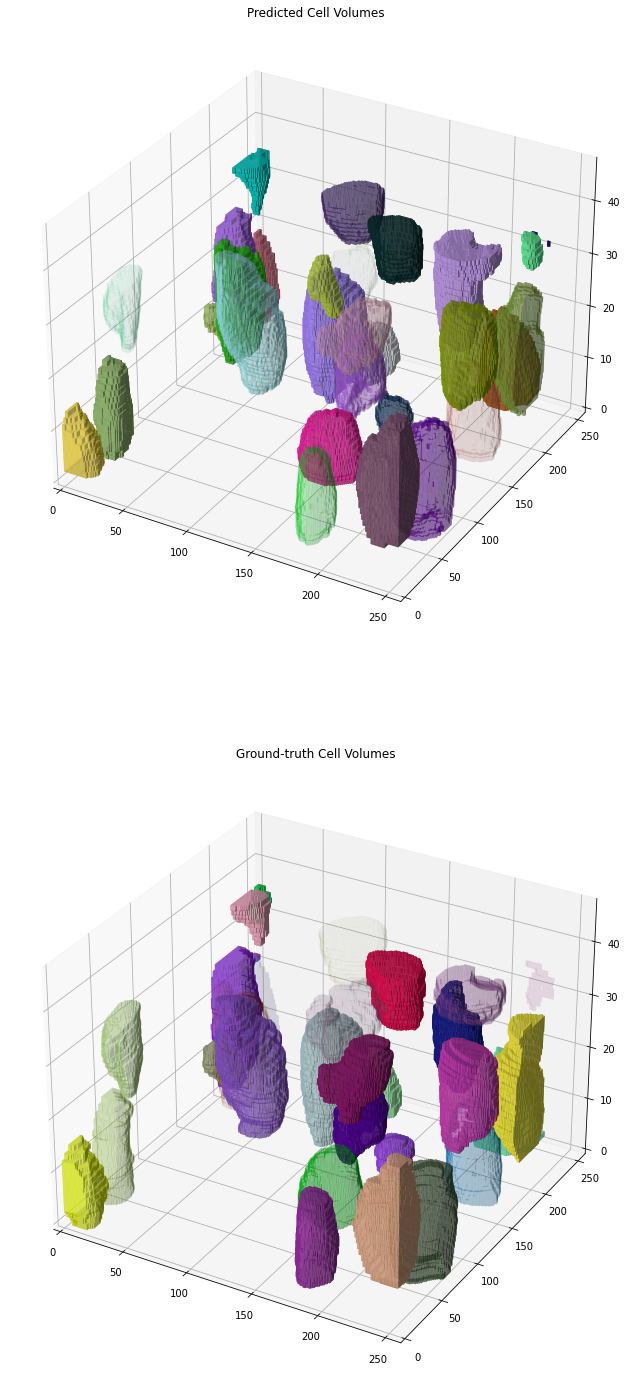

In [22]:
# Plot predicted/true centroids & volumes for one tile 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from skimage.measure import regionprops
#from scipy import ndimage

fig = plt.figure(figsize=(15, 25))
index = 0
x_min = 0
x_max = 256 + x_min
y_min = 0
y_max = 256 + y_min
z_min = 0
z_max = 47 + z_min
masks = y_pred[index, z_min:z_max, x_min:x_max, y_min:y_max]
gt_mask = y_true[index, z_min:z_max, x_min:x_max, y_min:y_max]

# Predicted Cell volumes
ax = fig.add_subplot(211, projection='3d')
ax.set_xlim3d(x_min, x_max)
ax.set_ylim3d(x_min, y_max)
ax.set_zlim3d(z_min, z_max)
plot_masks = np.rollaxis(np.squeeze(masks), 0, 3)
colors = np.empty(plot_masks.shape, dtype='<U9')
color_dict = dict()

for label in np.unique(plot_masks):
    if label != 0:
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(8)])]
    else:
        color = None#'#7A88CCC0'
    color_dict[label] = color
    colors = np.where(plot_masks==label, color, colors)
ax.voxels(plot_masks, facecolors=colors)
ax.set_title('Predicted Cell Volumes')

# Ground truth Cell Volumes
ax = fig.add_subplot(212, projection='3d')
ax.set_xlim3d(0,x_max)
ax.set_ylim3d(0,y_max)
ax.set_zlim3d(z_min, z_max)
plot_masks = np.rollaxis(np.squeeze(gt_mask), 0, 3)
colors = np.empty(plot_masks.shape, dtype='<U9')
color_dict = dict()

for label in np.unique(plot_masks):
    if label != 0:
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(8)])]
    else:
        color = None#'#7A88CCC0'
    color_dict[label] = color
    colors = np.where(plot_masks==label, color, colors)

ax.voxels(plot_masks, facecolors=colors)
ax.set_title('Ground-truth Cell Volumes')
plt.show()